In [1]:
load ../src/claude_run.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from typing import Tuple, List, Dict, Optional
import seaborn as sns


STARTING STROKE RISK INTERVENTION SIMULATION
Generating population of 50000 patients...
Model calibrated after 7 attempts. Top-250 PPV: 0.0235
Population generated. Overall risk: 0.0077
Top 250 average true risk: 0.0309
Monthly selection completed. Total treated: 12000
Outcome simulation completed:
  Treated patients: 12000, Event rate: 0.0082
  Untreated patients: 38000, Event rate: 0.0066
Running RD analysis for month 47 with threshold 0.0142
Using 29592 observations within bandwidth 0.01

RD Analysis Results:
Simple model: Effect=-0.001425, p=0.4764
Interaction model: Effect=-0.001451, p=0.4780

Summary of Results:
Naive difference in means: 0.001614
RD estimate (at threshold): -0.001451
Expected effect (intervention_efficacy × risk at threshold): -0.006964

SIMULATION COMPLETED



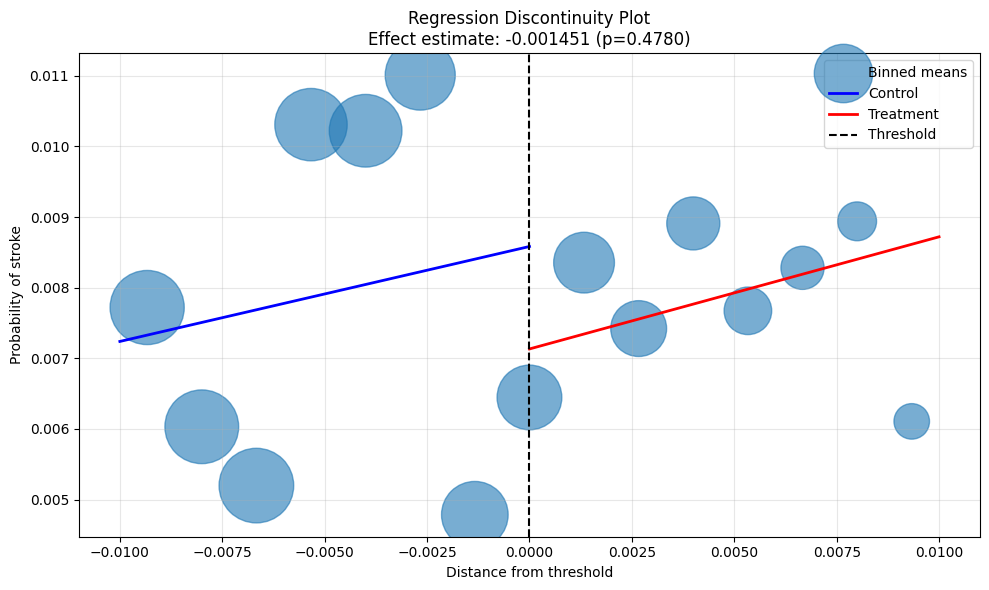

In [3]:
results = run_simulation_rd(
        pop_size=50_000,
        baseline_prevalence=0.089,
        top_k_factor=3,
        intervention_efficacy=0.3,
        top_k=250,
        months=48,
        bandwidth=0.01,
        random_seed=45
    )

In [52]:
df_pop = generate_population(pop_size=100_000, 
                       baseline_prevalence=0.05,
                       top_k_factor=2,
                       top_k=250,
                       noise_level=0.03)

Generating population of 100000 patients...
Model calibrated after 6 attempts. Top-250 PPV: 0.0081
Population generated. Overall risk: 0.0043
Top 250 average true risk: 0.0182


In [50]:
df, monthly_thresholds = simulate_monthly_intervention(
        df, 
        intervention_efficacy=0.20,
        top_k=250,
        months=12
    )

Monthly selection completed. Total treated: 3000
Outcome simulation completed:
  Treated patients: 3000, Event rate: 0.0050
  Untreated patients: 97000, Event rate: 0.0042


In [57]:
df[df['treated']==True]

,patient_id,true_risk,pred_score,treated,treatment_month,final_outcome
26,26,0.004182,0.025353,True,8.0,0
73,73,0.007908,0.027909,True,4.0,0
74,74,0.015719,0.037486,True,0.0,0
77,77,0.007707,0.024422,True,10.0,0
92,92,0.011640,0.027333,True,5.0,0
...,...,...,...,...,...,...
99892,99892,0.013197,0.031632,True,1.0,0
99913,99913,0.002577,0.028954,True,3.0,0
99935,99935,0.003848,0.026651,True,6.0,0
99945,99945,0.005200,0.026485,True,6.0,0


In [78]:
df_pop_cp = df_pop.copy()
df_pop_cp["treated"] = False
df_pop_cp["treatment_month"] = np.nan
df_pop_cp["final_outcome"] = 0  # Will fill in whether they had a stroke

In [79]:
untreated = df_pop_cp.loc[~df_pop_cp["treated"]]

In [80]:
 monthly_thresholds = []

In [81]:
selected = untreated.nlargest(250, "pred_score").index

In [82]:
selected

Index([43927, 95747, 89598, 71935, 92091, 81931, 35177, 98779, 60641, 99757,
       ...
       99641, 69747, 38369, 58732, 79534, 10233, 41553, 61720, 32258, 17686],
      dtype='int64', length=250)

In [83]:
# Record the threshold for this month (minimum pred_score among selected)
threshold = df_pop_cp.loc[selected, "pred_score"].min()
monthly_thresholds.append({"month": 1, "threshold": threshold, "n_selected": len(selected)})
        

In [126]:
mike = df_pop_cp.loc[selected]

In [134]:
mike.tail(20)

,patient_id,true_risk,pred_score,treated,treatment_month,final_outcome
52855,52855,0.005456,0.033491,True,1.0,0
67313,67313,0.009776,0.033405,True,1.0,0
66322,66322,0.005289,0.033400,True,1.0,0
21352,21352,0.009978,0.033395,True,1.0,0
92830,92830,0.010825,0.033393,True,1.0,0
62254,62254,0.007110,0.033383,True,1.0,0
29734,29734,0.003443,0.033378,True,1.0,0
33713,33713,0.003206,0.033364,True,1.0,0
31193,31193,0.005994,0.033342,True,1.0,0
40488,40488,0.009774,0.033341,True,1.0,0


In [84]:
monthly_thresholds

[{'month': 1, 'threshold': 0.033232798195645105, 'n_selected': 250}]

<Axes: >

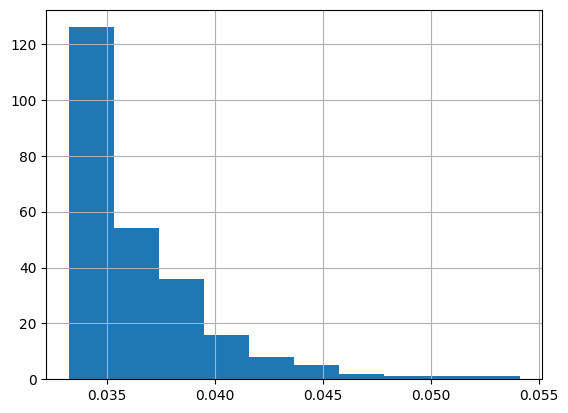

In [131]:
df_pop_cp.loc[selected, "pred_score"].hist()

In [88]:
 # Mark selected patients as treated in this month
df_pop_cp.loc[selected, "treated"] = True
df_pop_cp.loc[selected, "treatment_month"] = 1

In [89]:
treated_idx = df_pop_cp["treated"]

In [94]:
(np.random.binomial(n=1,p=(df_pop_cp.loc[treated_idx, "true_risk"] * (1 - intervention_efficacy))))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [95]:
1 - intervention_efficacy

0.8

In [99]:
df_pop_cp.loc[treated_idx, "true_risk"]*.8

600      0.003252
1007     0.007229
2293     0.003304
2307     0.004841
2788     0.008325
           ...   
98718    0.002131
98779    0.012704
99641    0.000402
99757    0.018881
99971    0.007880
Name: true_risk, Length: 250, dtype: float64